<a href="https://colab.research.google.com/github/riddhi-mehta-1721/NLP_Project/blob/master/Book_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP PROJECT

## RIDDHI MEHTA - J030
## HUSAIN GHADIALI - J056

# Importing Libraries

In [56]:
import pandas as pd
import numpy as np

import re
import pickle
import io
import json

import seaborn as sns
import matplotlib.pyplot as plt

import pydotplus
import pydot

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from tensorflow.python.keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPool1D, Dropout, Conv1D, MaxPooling1D
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from keras.callbacks import Callback
# from keras.models import Model
# from keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPool1D, Dropout
# from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model  
from keras.utils.vis_utils import model_to_dot

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")

import random

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Reading DataFrames: "train" & "test"

In [0]:
train = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Datasets/train.csv")
test = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Datasets/test.csv")

In [0]:
train.drop(columns = "Unnamed: 0", inplace = True)
test.drop(columns = "Unnamed: 0", inplace = True)

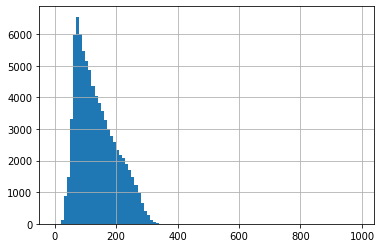

In [5]:
lens = train.comment_text.str.len()
lens.hist(bins = np.arange(0,1000,10))

# Creating X_train, X_test, Y_train, Y_test

In [0]:
X_train = train["comment_text"]
X_test = test["comment_text"]

In [0]:
Y_train = train.loc[:,("positive","negative")]
Y_test = test.loc[:,("positive","negative")]

In [0]:
Y_train = train.iloc[:,1:-2]
Y_test = test.iloc[:,1:-2]

In [0]:
# Y_train = np.asarray(Y_train).astype('float32').reshape((-1,1))
# Y_test = np.asarray(Y_test).astype('float32').reshape((-1,1))

# ## Use this code only when there is an error of logit and labels of not being the same dimensions...

In [60]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((82754,), (70,), (82754, 2), (70, 2))

# Tokenisation and Padding Sequences

In [0]:
max_features = 20000
tokenizer = Tokenizer(num_words = max_features, char_level=True)  

In [0]:
tokenizer.fit_on_texts(list(X_train))

In [0]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [0]:
tokenizer_json = tokenizer.to_json()
with io.open('/content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [0]:
maxlen = 400
X_train = pad_sequences(X_train, maxlen = maxlen, padding = "post")
X_test = pad_sequences(X_test, maxlen = maxlen, padding = "post")

# GloVe Embedding

In [0]:
embeddings_dictionary = dict()
vocab_size = len(tokenizer.word_index) + 1

glove_file = open(r"/content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/glove.6B.100d.txt", encoding="utf8")

for line in glove_file:
    
    records = line.split() 
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
    
glove_file.close()

embedding_matrix = np.zeros((vocab_size, 100))

for word, index in tokenizer.word_index.items():
    
    embedding_vector = embeddings_dictionary.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Neural Network - Type 0

### Layers:

1. Embedding (using **glove** embedding weights)
2. Convolutional 1D layer
3. Max Pooling
4. LSTM
5. Global Max Pooling
6. Dropout
7. Dense
8. Drop-out
9. Dense (final output layer)

### Input Data:

1. X_train: normal 
2. X_test: normal
3. Y_train: **6 columns** (toxic, severe_toxic, obscene, threat, insult, identity_hate)
4. Y_test: same as Y_train

### Architecture

In [0]:
inp = Input(shape = (maxlen,))

x = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(inp) # feature extraction

x = Conv1D(filters = 100, kernel_size = 4, padding = 'same', activation = 'relu')(x) # feature extraction

x = MaxPooling1D(pool_size=4)(x) # reduce dimensionality

x = LSTM(50, return_sequences = True, dropout = 0.1, recurrent_dropout = 0.1)(x) # feature extraction

x = GlobalMaxPool1D()(x) # reduce dimensionality

x = Dropout(0.1)(x) # reduce over fitting

x = Dense(50, activation = "relu")(x) # flattening and making a fully connected layer

x = Dropout(0.1)(x) # reduce over fitting

x = Dense(6, activation = "sigmoid")(x) # flattening and making a fully connected layer

model = Model(inputs = inp, outputs = x)

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

### Model Summary

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 100)           79300     
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 100)           40100     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 12, 50)            30200     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0     

### Fitting and Saving the BEST Model Weights

In [0]:
batch_size = 256
epochs = 10

file_path = "/content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn0.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor ='val_loss', verbose = 1, save_best_only = True, mode = 'min')

early = EarlyStopping(monitor = "val_loss", mode = "min", patience = 20)

callbacks_list = [checkpoint, early]

model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_test, Y_test), callbacks = callbacks_list, verbose = 1) 

Epoch 1/10
324/324 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.8007
Epoch 00001: val_loss improved from inf to 0.43220, saving model to /content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn0.hdf5
324/324 [==============================] - 21s 65ms/step - loss: 0.1502 - accuracy: 0.8007 - val_loss: 0.4322 - val_accuracy: 0.9900
Epoch 2/10
323/324 [============================>.] - ETA: 0s - loss: 0.0965 - accuracy: 0.9490
Epoch 00002: val_loss did not improve from 0.43220
324/324 [==============================] - 20s 63ms/step - loss: 0.0966 - accuracy: 0.9490 - val_loss: 0.4368 - val_accuracy: 0.9900
Epoch 3/10
323/324 [============================>.] - ETA: 0s - loss: 0.0874 - accuracy: 0.9777
Epoch 00003: val_loss improved from 0.43220 to 0.36673, saving model to /content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn0.hdf5
324/324 [==============================] - 21s 64ms/step - loss: 0.0873 - accuracy: 0.9777 - val_loss: 

# Neural Network - Type 1

### Layers:

1. Embedding (**WITHOUT glove**)
2. Convolutional 1D layer
3. Max Pooling
4. LSTM
5. Global Max Pooling
6. Dropout
7. Dense
8. Drop-out
9. Dense (final output layer)

### Input Data:

1. X_train: normal 
2. X_test: normal
3. Y_train: **6 columns** (toxic, severe_toxic, obscene, threat, insult, identity_hate)
4. Y_test: same as Y_train

### Architecture

In [41]:
vocab_size = len(tokenizer.word_index) + 1

inp = Input(shape = (maxlen,))

x = Embedding(vocab_size, 250)(inp)

x = Conv1D(filters = 100, kernel_size = 4, padding = 'same', activation = 'relu')(x) 

x = MaxPooling1D(pool_size=4)(x)

x = LSTM(50, return_sequences = True, dropout = 0.1, recurrent_dropout = 0.1)(x)

x = GlobalMaxPool1D()(x)

x = Dense(50, activation = "relu")(x)

x = Dropout(0.2)(x)

x = Dense(6, activation = "sigmoid")(x)

model = Model(inputs = inp, outputs = x)

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

### Model Summary

In [42]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 400, 250)          198250    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 400, 100)          100100    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           30200     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550

### Fitting and Saving the BEST Model Weights

In [43]:
batch_size = 256
epochs = 10

file_path = "/content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn1_new.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor ='val_loss', verbose = 1, save_best_only = True, mode = 'min')

early = EarlyStopping(monitor = "val_loss", mode = "min", patience = 20)

callbacks_list = [checkpoint, early]

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_test, Y_test), callbacks = callbacks_list, verbose = 1) 

Epoch 1/10
324/324 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.6198
Epoch 00001: val_loss improved from inf to 0.89243, saving model to /content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn1_new.hdf5
324/324 [==============================] - 129s 398ms/step - loss: 0.1492 - accuracy: 0.6198 - val_loss: 0.8924 - val_accuracy: 0.6714
Epoch 2/10
324/324 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.8573
Epoch 00002: val_loss did not improve from 0.89243
324/324 [==============================] - 129s 397ms/step - loss: 0.0847 - accuracy: 0.8573 - val_loss: 0.9617 - val_accuracy: 0.9286
Epoch 3/10
324/324 [==============================] - ETA: 0s - loss: 0.0752 - accuracy: 0.9382
Epoch 00003: val_loss improved from 0.89243 to 0.80936, saving model to /content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn1_new.hdf5
324/324 [==============================] - 129s 398ms/step - loss: 0.0752 - accuracy: 0.938

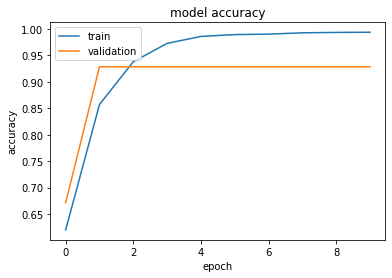

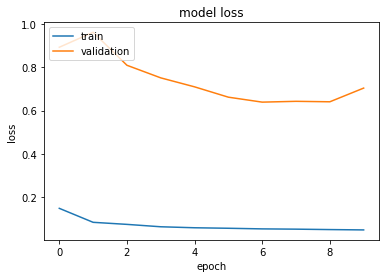

In [44]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Prediction on X_test

In [45]:
model = load_model(r"/content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn1_new.hdf5")
y_pred = model.predict(X_test, verbose = 1)

outer_list = []

for y in y_pred:
  
  inner_list = []

  for i in y:

    if i >= 0.5:
      inner_list.append(1)

    else:
      inner_list.append(0)

  outer_list.append(inner_list)

df = pd.DataFrame.from_records(outer_list)
df.columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
df

3/3 [==============================] - 0s 17ms/step


,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
65,1,0,1,0,1,0
66,1,0,1,0,1,0
67,1,0,1,0,1,0
68,1,0,1,0,0,0


In [49]:
print("F1 score = " + str(f1_score(Y_test, df, average = 'samples')))
print(classification_report(Y_test, df))

F1 score = 0.5424489795918367
              precision    recall  f1-score   support

           0       0.96      0.89      0.92        55
           1       0.00      0.00      0.00        11
           2       0.90      0.77      0.83        48
           3       0.00      0.00      0.00        24
           4       0.95      0.82      0.88        44
           5       0.00      0.00      0.00        26

   micro avg       0.94      0.59      0.72       208
   macro avg       0.47      0.41      0.44       208
weighted avg       0.66      0.59      0.62       208
 samples avg       0.68      0.48      0.54       208



# Neural Network - Type 2

### Layers:

1. Embedding (using **glove** embedding weights)
2. Convolutional 1D layer
3. Max Pooling
4. LSTM
5. Global Max Pooling
6. Dropout
7. Dense
8. Drop-out
9. Dense (final output layer)

### Input Data:

1. X_train: normal 
2. X_test: normal
3. Y_train: **2 columns** (positive, negative)
4. Y_test: same as Y_train

### Architecture

In [0]:
inp = Input(shape = (maxlen,))

x = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(inp)

x = Conv1D(filters = 100, kernel_size = 4, padding = 'same', activation = 'relu')(x)

x = MaxPooling1D(pool_size=4)(x) 

x = LSTM(50, return_sequences = True, dropout = 0.1, recurrent_dropout = 0.1)(x)

x = GlobalMaxPool1D()(x)

x = Dropout(0.1)(x)

x = Dense(50, activation = "relu")(x)

x = Dropout(0.1)(x)

x = Dense(2, activation = "sigmoid")(x)

model = Model(inputs = inp, outputs = x)

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

### Model Summary

In [0]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 100)           79300     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 100)           40100     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 50)            30200     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0   

### Fitting and Saving the BEST Model Weights

In [0]:
batch_size = 256
epochs = 10

file_path = "/content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn2.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor ='val_loss', verbose = 1, save_best_only = True, mode = 'min')

early = EarlyStopping(monitor = "val_loss", mode = "min", patience = 20)

callbacks_list = [checkpoint, early]

model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_test, Y_test), callbacks = callbacks_list, verbose = 1) 

Epoch 1/10
323/324 [============================>.] - ETA: 0s - loss: 0.2978 - accuracy: 0.9055
Epoch 00001: val_loss improved from inf to 0.93815, saving model to /content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn2.hdf5
324/324 [==============================] - 22s 68ms/step - loss: 0.2973 - accuracy: 0.9055 - val_loss: 0.9381 - val_accuracy: 0.6700
Epoch 2/10
324/324 [==============================] - ETA: 0s - loss: 0.2258 - accuracy: 0.9330
Epoch 00002: val_loss did not improve from 0.93815
324/324 [==============================] - 22s 69ms/step - loss: 0.2258 - accuracy: 0.9330 - val_loss: 0.9624 - val_accuracy: 0.6500
Epoch 3/10
324/324 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.9386
Epoch 00003: val_loss improved from 0.93815 to 0.64489, saving model to /content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn2.hdf5
324/324 [==============================] - 22s 69ms/step - loss: 0.2063 - accuracy: 0.9386 - val_loss: 

# Neural Network - Type 3

### Layers:

1. Embedding (**WITHOUT glove**)
2. Convolutional 1D layer
3. Max Pooling
4. LSTM
5. Global Max Pooling
6. Dropout
7. Dense
8. Drop-out
9. Dense (final output layer)

### Input Data:

1. X_train: normal 
2. X_test: normal
3. Y_train: **2 columns** (positive, negative)
4. Y_test: same as Y_train

### Architecture

In [66]:
vocab_size = len(tokenizer.word_index) + 1

inp = Input(shape = (maxlen,))

x = Embedding(vocab_size, 250)(inp)

x = Conv1D(filters = 100, kernel_size = 4, padding = 'same', activation = 'relu')(x) 

x = MaxPooling1D(pool_size=4)(x)

x = LSTM(50, return_sequences = True, dropout = 0.1, recurrent_dropout = 0.1)(x)

x = GlobalMaxPool1D()(x)

x = Dense(50, activation = "relu")(x)

x = Dropout(0.2)(x)

x = Dense(2, activation = "softmax")(x)

model = Model(inputs = inp, outputs = x)

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

### Model Summary

In [67]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 400)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 400, 250)          198250    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 400, 100)          100100    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 100, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 50)           30200     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550

### Fitting and Saving the BEST Model Weights

In [70]:
batch_size = 256
epochs = 4

file_path = "/content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn3_new.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor ='val_loss', verbose = 1, save_best_only = True, mode = 'min')

early = EarlyStopping(monitor = "val_loss", mode = "min", patience = 20)

callbacks_list = [checkpoint, early]

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_test, Y_test), callbacks = callbacks_list, verbose = 1) 

Epoch 1/4
324/324 [==============================] - ETA: 0s - loss: 0.1708 - accuracy: 0.9426
Epoch 00001: val_loss improved from inf to 0.56475, saving model to /content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn3_new.hdf5
324/324 [==============================] - 129s 399ms/step - loss: 0.1708 - accuracy: 0.9426 - val_loss: 0.5648 - val_accuracy: 0.7857
Epoch 2/4
324/324 [==============================] - ETA: 0s - loss: 0.1382 - accuracy: 0.9534
Epoch 00002: val_loss improved from 0.56475 to 0.40452, saving model to /content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn3_new.hdf5
324/324 [==============================] - 129s 399ms/step - loss: 0.1382 - accuracy: 0.9534 - val_loss: 0.4045 - val_accuracy: 0.8286
Epoch 3/4
324/324 [==============================] - ETA: 0s - loss: 0.1190 - accuracy: 0.9598
Epoch 00003: val_loss improved from 0.40452 to 0.33331, saving model to /content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn3_ne

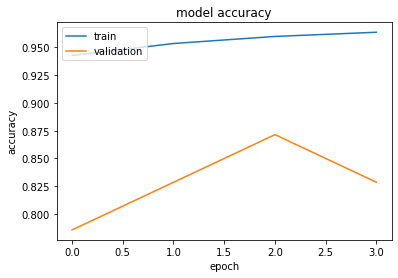

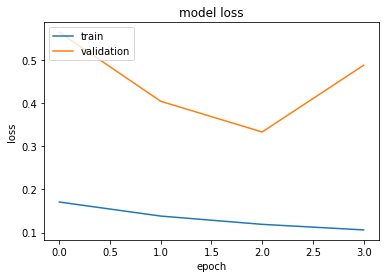

In [71]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Predicting on X_test

In [73]:
model = load_model(r"/content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn3_new.hdf5")
y_pred = model.predict(X_test, verbose = 1)

outer_list = []

for y in y_pred:
  
  inner_list = []

  for i in y:

    if i >= 0.5:
      inner_list.append(1)

    else:
      inner_list.append(0)

  outer_list.append(inner_list)

df = pd.DataFrame.from_records(outer_list)
df.columns = ["positive","negative"]
df

3/3 [==============================] - 0s 18ms/step


,positive,negative
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
65,0,1
66,0,1
67,0,1
68,0,1


In [81]:
test.iloc[2,0]

'title edit wondering edit title article made instead called antun wanted remname title autun name would easy people find could'

In [74]:
print("F1 score = " + str(f1_score(Y_test, df, average = 'samples')))
print(classification_report(Y_test, df))

F1 score = 0.8714285714285714
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        10
           1       1.00      0.85      0.92        60

   micro avg       0.87      0.87      0.87        70
   macro avg       0.76      0.93      0.80        70
weighted avg       0.93      0.87      0.89        70
 samples avg       0.87      0.87      0.87        70



# Neural Network - Type 4

### Layers:

1. Embedding (using **glove** embedding weights)
2. LSTM
3. Dropout
4. Dense
5. Drop-out
6. Dense (final output layer)

### Input Data:

1. X_train: normal 
2. X_test: normal
3. Y_train: **6 columns** (toxic, severe_toxic, obscene, threat, insult, identity_hate)
4. Y_test: same as Y_train

### Architecture

In [58]:
inp = Input(shape = (maxlen,))

x = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(inp)

x = LSTM(50, return_sequences = True, dropout = 0.1, recurrent_dropout = 0.1)(x)

x = GlobalMaxPool1D()(x)

x = Dense(50, activation = "relu")(x)

x = Dense(6, activation = "sigmoid")(x)

model = Model(inputs = inp, outputs = x)

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

### Model Summary

In [59]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 100)          79300     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           30200     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 306       
Total params: 112,356
Trainable params: 33,056
Non-trainable params: 79,300
_________________________________________________

### Fitting and Saving the BEST Model Weights

In [60]:
batch_size = 256
epochs = 10

file_path = "/content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn4.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor ='val_loss', verbose = 1, save_best_only = True, mode = 'min')

early = EarlyStopping(monitor = "val_loss", mode = "min", patience = 20)

callbacks_list = [checkpoint, early]

model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_test, Y_test), callbacks = callbacks_list, verbose = 1) 

Epoch 1/10
324/324 [==============================] - ETA: 0s - loss: 0.1795 - accuracy: 0.8768
Epoch 00001: val_loss improved from inf to 1.37647, saving model to /content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn4.hdf5
324/324 [==============================] - 107s 331ms/step - loss: 0.1795 - accuracy: 0.8768 - val_loss: 1.3765 - val_accuracy: 0.9286
Epoch 2/10
324/324 [==============================] - ETA: 0s - loss: 0.1032 - accuracy: 0.9935
Epoch 00002: val_loss improved from 1.37647 to 1.10825, saving model to /content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn4.hdf5
324/324 [==============================] - 106s 327ms/step - loss: 0.1032 - accuracy: 0.9935 - val_loss: 1.1083 - val_accuracy: 0.8571
Epoch 3/10
324/324 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 0.9896
Epoch 00003: val_loss improved from 1.10825 to 0.97538, saving model to /content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn4.hdf5
32

### Calculating F1 Score for this neural network model

In [61]:
model = load_model(r"/content/drive/My Drive/Colab Notebooks/NLP - Sem 6/Project/Models/nn4.hdf5")
y_pred = model.predict(X_test, verbose = 1)

outer_list = []

for y in y_pred:
  
  inner_list = []

  for i in y:

    if i >= 0.5:
      inner_list.append(1)

    else:
      inner_list.append(0)

  outer_list.append(inner_list)

y_pred = pd.DataFrame.from_records(outer_list)
y_pred.columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_pred.shape

3/3 [==============================] - 0s 17ms/step


(70, 6)

In [72]:
print("F1 score = " + str(f1_score(Y_test, y_pred, average = 'samples')))
print(classification_report(Y_test, y_pred))

F1 score = 0.4672108843537415
              precision    recall  f1-score   support

           0       0.98      0.80      0.88        55
           1       0.57      0.36      0.44        11
           2       0.89      0.65      0.75        48
           3       0.00      0.00      0.00        24
           4       0.97      0.66      0.78        44
           5       0.00      0.00      0.00        26

   micro avg       0.92      0.52      0.66       208
   macro avg       0.57      0.41      0.48       208
weighted avg       0.70      0.52      0.59       208
 samples avg       0.60      0.42      0.47       208



# Summary of all the models:



---
> **Using GloVe Embeddings**

There are 2 models which uses GloVe Embeddings:

1. Neural Network - ***Type 0***

*   It uses 6 one-hot-encoded columns which forms the Y_train and Y_test. 
*   These columns are ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
* The best training and validation accuracy is given by:

**loss: 0.0737 - accuracy: 0.9935 - val_loss: 0.3127 - val_accuracy: 0.9900**

2. Neural Network - ***Type 2***

*   It uses 2 one-hot-encoded columns which forms the Y_train and Y_test. 
*   These columns are ["positive", "negative"]
* The best training and validation accuracy is given by:

**loss: 0.1802 - accuracy: 0.9447 - val_loss: 0.5740 - val_accuracy: 0.7800**



---
> **Without GloVe Embeddings**

There are 2 models which uses keras.layers.Embedding (without GloVe Embedding)

1. Neural Network - ***Type 1***

*   It uses 6 one-hot-encoded columns which forms the Y_train and Y_test. 
*   These columns are ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
* The best training and validation accuracy is given by:

**loss: 0.0730 - accuracy: 0.9948 - val_loss: 0.3138 - val_accuracy: 0.9900**

2. Neural Network - ***Type 3***

*   It uses 2 one-hot-encoded columns which forms the Y_train and Y_test. 
*   These columns are ["positive", "negative"]
* The best training and validation accuracy is given by:

**loss: 0.1434 - accuracy: 0.9552 - val_loss: 0.5210 - val_accuracy: 0.8300**


# --------------------- THE END ---------------------